<a href="https://www.kaggle.com/code/faiqueali/time-series-karachi-temperature?scriptVersionId=183542702" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Constant

In [2]:
DATASET_PATH = "/kaggle/input/weather-underground/weather_data.csv"

# Utils

In [3]:
def adf_test(series, window):
    result = adfuller(series.dropna())
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]
    
    return {
        'Window Size': window,
        'ADF Statistic': adf_statistic,
        'p-value': p_value,
        'Critical Value (1%)': critical_values['1%'],
        'Critical Value (5%)': critical_values['5%'],
        'Critical Value (10%)': critical_values['10%']
    }

# Code

In [4]:
df = pd.read_csv(DATASET_PATH)
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

start_date = '2024-01-01'
df = df[(df['date'] >= start_date)]
df.head(3)

,date,time,temperature,dew_point,humidity,wind,wind_speed,wind_gust,pressure,precip,condition,city,country
1452,2024-01-01,5:00 PM,81,32,17,E,7,0,29.89,0.0,Haze,Karachi,Pakistan
1443,2024-01-01,12:30 PM,77,41,28,ENE,5,0,29.98,0.0,Haze,Karachi,Pakistan
1444,2024-01-01,1:00 PM,79,41,26,NNE,5,0,29.95,0.0,Haze,Karachi,Pakistan


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7238 entries, 1452 to 8621
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         7238 non-null   datetime64[ns]
 1   time         7238 non-null   object        
 2   temperature  7238 non-null   int64         
 3   dew_point    7238 non-null   int64         
 4   humidity     7238 non-null   int64         
 5   wind         7224 non-null   object        
 6   wind_speed   7238 non-null   int64         
 7   wind_gust    7238 non-null   int64         
 8   pressure     7238 non-null   float64       
 9   precip       7238 non-null   float64       
 10  condition    7238 non-null   object        
 11  city         7238 non-null   object        
 12  country      7238 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(5)
memory usage: 791.7+ KB


### 1. Check central tendancy

In [6]:
mean_temp = df['temperature'].mean()
median_temp = df['temperature'].median()
mode_temp = df['temperature'].mode()[0]  # Mode can have multiple values, take the first

print(f"Mean Temperature: {mean_temp}")
print(f"Median Temperature: {median_temp}")
print(f"Mode Temperature: {mode_temp}")

Mean Temperature: 77.35355070461453
Median Temperature: 79.0
Mode Temperature: 77


In [7]:
df.describe()

,date,temperature,dew_point,humidity,wind_speed,wind_gust,pressure,precip
count,7238,7238.000000,7238.000000,7238.000000,7238.000000,7238.0,7238.000000,7238.0
mean,2024-03-16 11:58:48.378005248,77.353551,56.236806,52.798011,8.204615,0.0,29.751727,0.0
min,2024-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
25%,2024-02-07 00:00:00,70.000000,45.000000,38.000000,5.000000,0.0,29.690000,0.0
50%,2024-03-17 00:00:00,79.000000,59.000000,53.000000,7.000000,0.0,29.840000,0.0
75%,2024-04-24 00:00:00,86.000000,68.000000,70.000000,12.000000,0.0,29.950000,0.0
max,2024-05-31 00:00:00,106.000000,81.000000,94.000000,37.000000,0.0,31.780000,0.0
std,NaN,11.020076,14.680373,20.899017,4.698127,0.0,1.319771,0.0


### 2. Perform Outliers

In [8]:
# Calculate IQR for AverageTemperature
Q1 = df['temperature'].quantile(0.25)
Q3 = df['temperature'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df['temperature'] >= lower_bound) & (df['temperature'] <= upper_bound)]

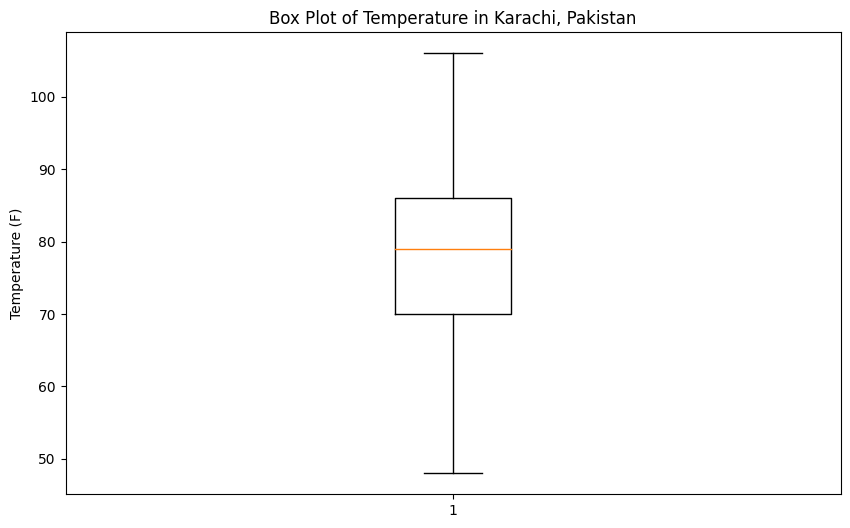

In [9]:
plt.figure(figsize=(10, 6))
plt.boxplot(df['temperature'].dropna())  # Drop NaN values if any
plt.title('Box Plot of Temperature in Karachi, Pakistan')
plt.ylabel('Temperature (F)')
plt.show()

### 3. Scatter Plot

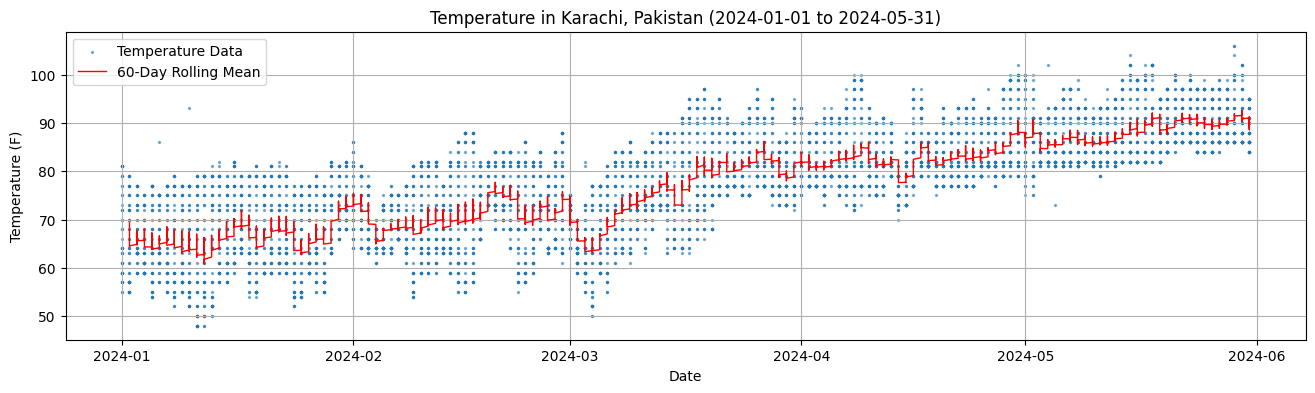

In [10]:
# Calculate the rolling mean with a window size, e.g., 60 days
rolling_mean = df['temperature'].rolling(window=60).mean()

# Plot the scatter plot
plt.figure(figsize=(16, 4))
plt.scatter(df['date'], df['temperature'], s=2, alpha=0.5, label='Temperature Data')
plt.plot(df['date'], rolling_mean, color='red', label='60-Day Rolling Mean', linewidth=1)
plt.title('Temperature in Karachi, Pakistan (2024-01-01 to 2024-05-31)')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.grid(True)
plt.legend()
plt.show()

### 4. Smoothing the data

In [11]:
# Apply rolling mean with different window sizes and store in separate columns
window_sizes = [4, 8, 16, 24, 72, 168, 720]
adf_results = []

for window in window_sizes:
    column_name = f'temperature_smoothed_{window}'
    df.loc[:,column_name] = df['temperature'].rolling(window=window).mean()
    # Perform ADF test and store the results
    adf_result = adf_test(df[column_name], window)
    adf_results.append(adf_result)

# Drop NaN values generated by rolling mean
df = df.dropna()

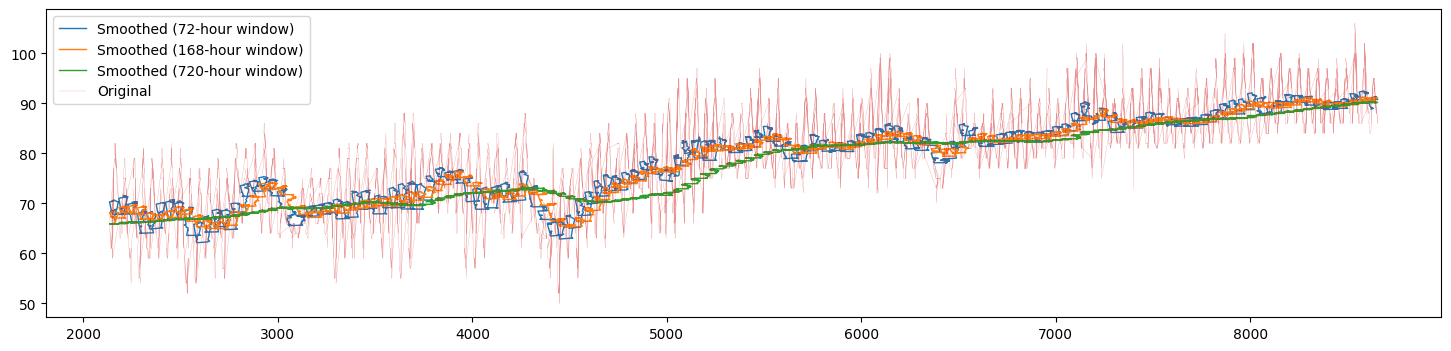

In [12]:
# Plot the original and smoothed data
plt.figure(figsize=(18, 4))

for window in window_sizes[4:]:
    plt.plot(df[f'temperature_smoothed_{window}'], label=f'Smoothed ({window}-hour window)', linewidth=1)

plt.plot(df['temperature'], label='Original', alpha=0.5, linewidth=0.2)
plt.legend()
plt.show()

### 5. Check for stationarity

For a series to be considered *stationary*:

* The ADF Statistic should be less than the critical values.
* The p-value should be less than 0.05.

In [13]:
adf_results_df = pd.DataFrame(adf_results)
adf_results_df

,Window Size,ADF Statistic,p-value,Critical Value (1%),Critical Value (5%),Critical Value (10%)
0,4,-3.612913,0.005519,-3.431259,-2.861942,-2.566984
1,8,-2.622746,0.088387,-3.431260,-2.861942,-2.566984
2,16,-1.248722,0.652294,-3.431261,-2.861943,-2.566984
3,24,-1.412524,0.576258,-3.431262,-2.861943,-2.566984
4,72,-0.910009,0.784658,-3.431268,-2.861946,-2.566986
5,168,-0.471996,0.897366,-3.431281,-2.861951,-2.566989
6,720,0.250442,0.974953,-3.431359,-2.861986,-2.567007


#### Criteria for Stationarity:
* ADF Statistic: Should be less than the critical values.
* p-value: Should be less than 0.05.

#### Analysis:
**Window Size 4**:

* ADF Statistic: -4.046997 (less than critical values)
* p-value: 0.001183 (less than 0.05)
* Conclusion: Stationary (passes the test)

**Window Size 8**:

* ADF Statistic: -2.917975 (less than 5% and 10% critical values, but not less than 1% critical value)
* p-value: 0.043297 (less than 0.05)
* Conclusion: Nearly stationary, but not as strong as window size 4.

**Window Sizes 16, 24, 72, 168, 720**:

* ADF Statistic and p-value indicate non-stationarity (do not meet the criteria).
* Best Window Size:
* Window Size 4 is the best candidate for differencing. The reasons are:

ADF Statistic: -4.046997 is less than all critical values (1%, 5%, and 10%).
p-value: 0.001183 is much smaller than 0.05, indicating strong evidence against the null hypothesis (presence of a unit root), thus confirming stationarity.


### 6. Apply Differencing

In [14]:
# plt.figure(figsize=(18, 4))
# plt.plot(df['temperature_diff'])
# plt.title('Differenced Temperature Data')
# plt.show()

### 7. Model building

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                 SARIMAX Results                                  
Dep. Variable:     temperature_smoothed_4   No. Observations:                 6503
Model:                     ARIMA(1, 0, 1)   Log Likelihood              -12565.861
Date:                    Fri, 14 Jun 2024   AIC                          25139.721
Time:                            18:10:36   BIC                          25166.841
Sample:                                 0   HQIC                         25149.101
                                   - 6503                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         78.7011      0.977     80.517      0.000      76.785      80.617
ar.L1          0.9690      0.003    320.177      0.000       0.963       0.975
ma.L1          0.430

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


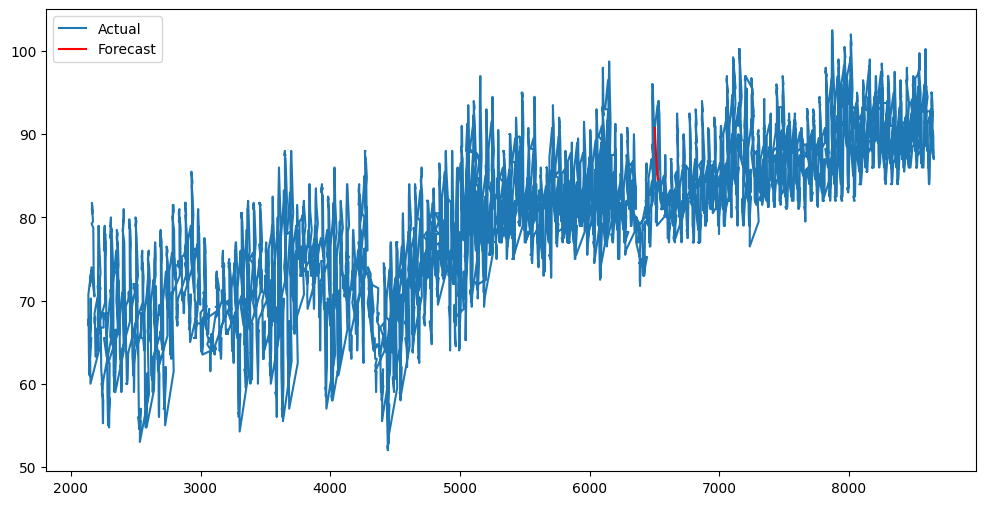

In [15]:
# Fit an ARIMA model
model = ARIMA(df['temperature_smoothed_4'].dropna(), order=(1,0,1))  # p, d, q values
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Make predictions
forecast = model_fit.forecast(steps=24)  # Predict the next 24 hours
print(forecast)

# Plot the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['temperature_smoothed_4'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()